#Imports and load source data

In [0]:
import pyspark.sql.functions as f
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from pyspark.sql.window import Window

from cycler import cycler

#charts settings
red_palette = sns.color_palette("Reds", n_colors=5)[::-1]
sns.set_theme(style="white", palette=red_palette)
plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["axes.prop_cycle"] = cycler(color=red_palette)

In [0]:
offers_df = spark.table("hive_metastore.default.offers_json")
customers_df = spark.table("hive_metastore.default.profile_json")
transactions_df = spark.table("hive_metastore.default.transactions_json")

#EDA


## Offers

In [0]:
offers_df.display()

channels discount_value duration id min_value offer_type List(email, mobile, social) 10 7.0 ae264e3637204a6fb9bb56bc8210ddfd 10 bogo List(web, email, mobile, social) 10 5.0 4d5c57ea9a6940dd891ad53e9dbe8da0 10 bogo List(web, email, mobile) 0 4.0 3f207df678b143eea3cee63160fa8bed 0 informational List(web, email, mobile) 5 7.0 9b98b8c7a33c4b65b9aebfe6a799e6d9 5 bogo List(web, email) 5 10.0 0b1e1539f2cc45b7b9fa7c272da2e1d7 20 discount List(web, email, mobile, social) 3 7.0 2298d6c36e964ae4a3e7e9706d1fb8c2 7 discount List(web, email, mobile, social) 2 10.0 fafdcd668e3743c1bb461111dcafc2a4 10 discount List(email, mobile, social) 0 3.0 5a8bc65990b245e5a138643cd4eb9837 0 informational List(web, email, mobile, social) 5 5.0 f19421c1d4aa40978ebb69ca19b0e20d 5 bogo List(web, email, mobile) 2 7.0 2906b810c7d4411798c6938adc9daaa5 10 discount

In [0]:
offers_df.describe().show()

+-------+------------------+------------------+--------------------+------------------+-------------+
|summary|    discount_value|          duration|            offer_id|         min_value|   offer_type|
+-------+------------------+------------------+--------------------+------------------+-------------+
|  count|                10|                10|                  10|                10|           10|
|   mean|               4.2|               6.5|                NULL|               7.7|         NULL|
| stddev|3.5839146815241634|2.3213980461973533|                NULL|5.8319045869347965|         NULL|
|    min|                 0|               3.0|0b1e1539f2cc45b7b...|                 0|         bogo|
|    max|                10|              10.0|fafdcd668e3743c1b...|                20|informational|
+-------+------------------+------------------+--------------------+------------------+-------------+



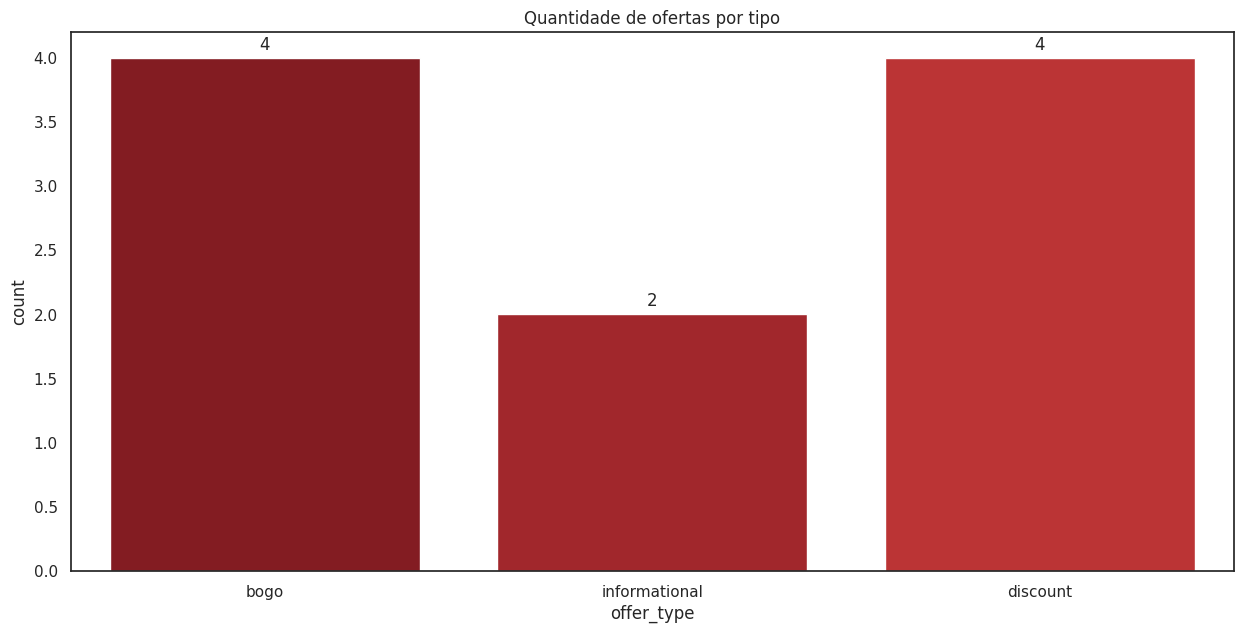

In [0]:
count_offers_type = (
    offers_df.groupBy("offer_type")
    .agg(f.count("*").alias("count"))
    .toPandas()
)

ax = sns.barplot(x="offer_type", y="count", data=count_offers_type)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
plt.title("Quantidade de ofertas por tipo")
plt.show()

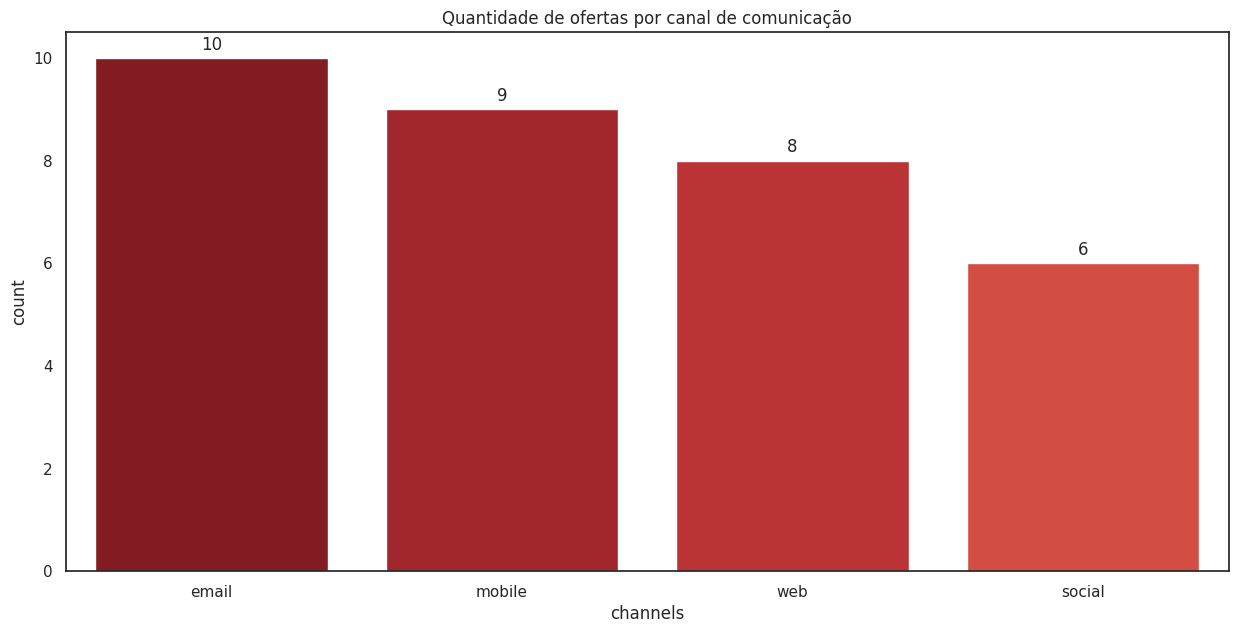

In [0]:
channels_pdf = (
    offers_df.select(f.explode("channels").alias("channels"))
    .groupBy("channels")
    .agg(f.count("*").alias("count"))
    .orderBy(f.desc("count"))
    .toPandas()
)

ax = sns.barplot(x="channels", y="count", data=channels_pdf)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
plt.title("Quantidade de ofertas por canal de comunicação")
plt.show()

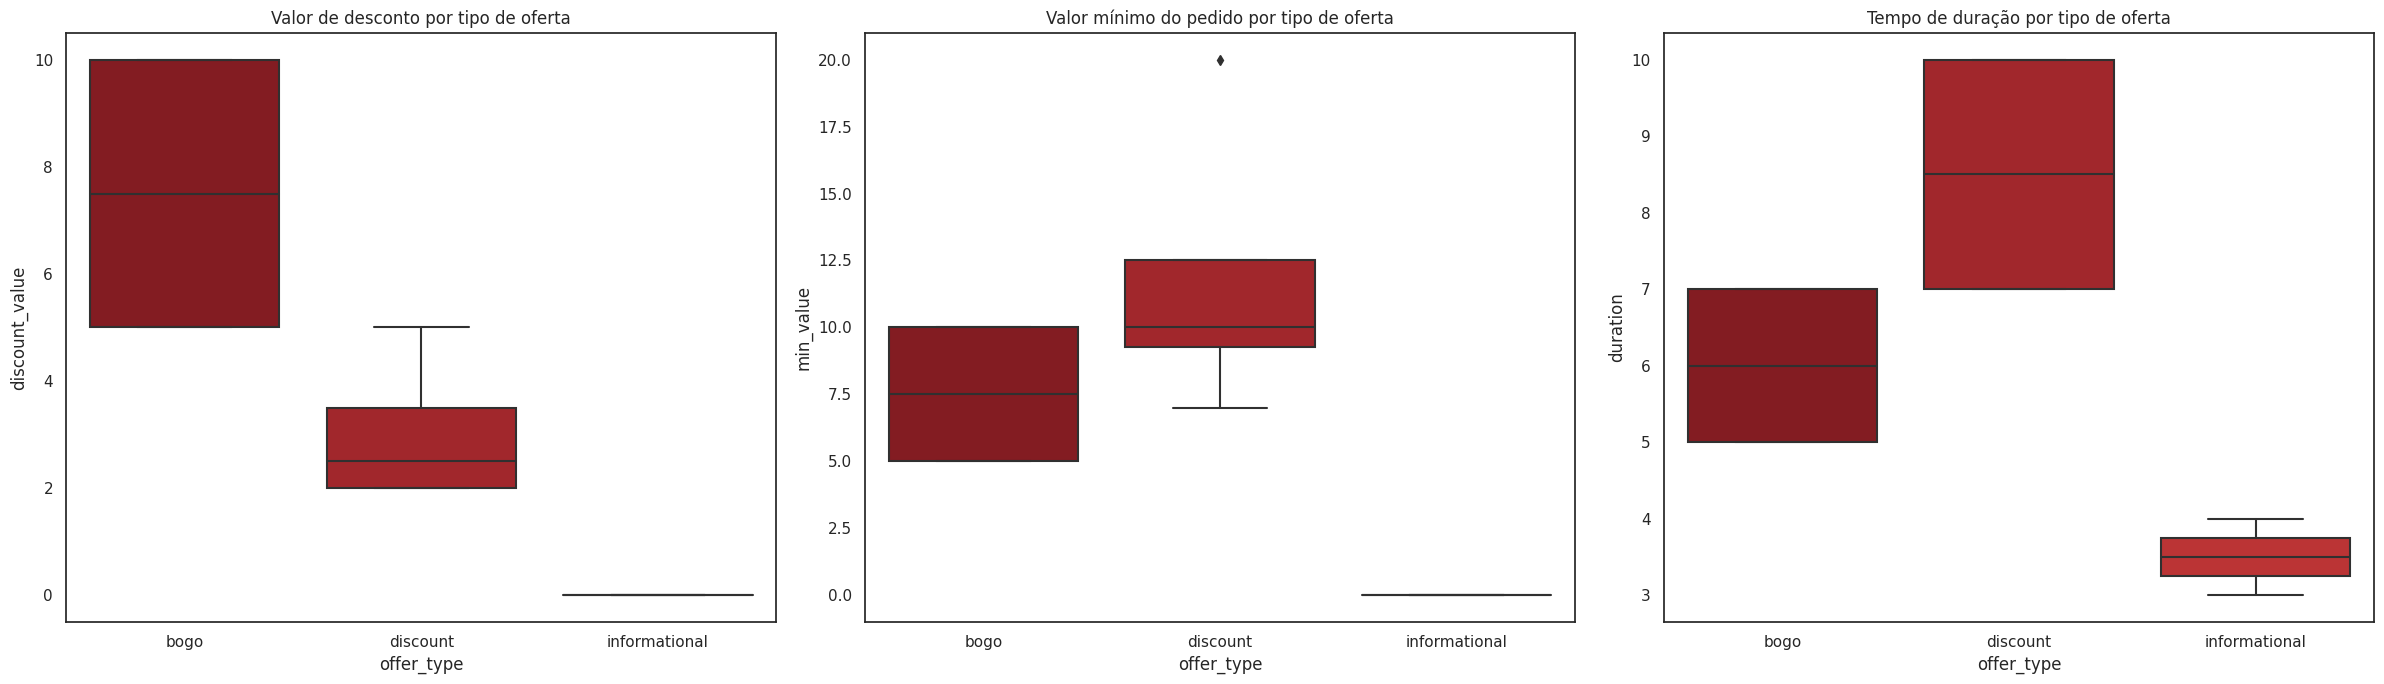

In [0]:
offers_pdf = (
    offers_df.select("offer_type", "discount_value", "min_value", "duration")
    .orderBy("offer_type")
    .toPandas())

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

sns.boxplot(x="offer_type", y="discount_value", data=offers_pdf, ax=axes[0])
axes[0].set_title("Valor de desconto por tipo de oferta")

sns.boxplot(x="offer_type", y="min_value", data=offers_pdf, ax=axes[1])
axes[1].set_title("Valor mínimo do pedido por tipo de oferta")

sns.boxplot(x="offer_type", y="duration", data=offers_pdf, ax=axes[2])
axes[2].set_title("Tempo de duração por tipo de oferta")

plt.tight_layout()
plt.show()

## Customers

A análise de usuários ficará concentrada em:
- Qual é o perfil demográfico e financeiro dos clientes? (Distribuição de idade, gênero, limite de cartão)
- Existem grupos representativos por faixa etária?
- Há outliers em idade ou limites? (Idade < 15 ou > 100? ou Limites negativos ou nulos?)
- Existe correlação entre idade e limite de cartão?
  - Há grupos de clientes que podem responder melhor a determinados tipos de oferta?
  - Ex: clientes mais jovens têm menor limite de cartão → podem preferir ofertas de menor valor mínimo
- Clientes com maior limite convertem mais?
- Clientes antigos (tempo de conta) engajam mais? 

In [0]:
customers_df.display()

age credit_card_limit gender id registered_on 118 null null 68be06ca386d4c31939f3a4f0e3dd783 20170212 55 112000.0 F 0610b486422d4921ae7d2bf64640c50b 20170715 118 null null 38fe809add3b4fcf9315a9694bb96ff5 20180712 75 100000.0 F 78afa995795e4d85b5d9ceeca43f5fef 20170509 118 null null a03223e636434f42ac4c3df47e8bac43 20170804 68 70000.0 M e2127556f4f64592b11af22de27a7932 20180426 118 null null 8ec6ce2a7e7949b1bf142def7d0e0586 20170925 118 null null 68617ca6246f4fbc85e91a2a49552598 20171002 65 53000.0 M 389bc3fa690240e798340f5a15918d5c 20180209 118 null null 8974fc5686fe429db53ddde067b88302 20161122 118 null null c4863c7985cf408faee930f111475da3 20170824 118 null null 148adfcaa27d485b82f323aaaad036bd 20150919 58 51000.0 M 2eeac8d8feae4a8cad5a6af0499a211d 20171111 61 57000.0 F aa4862eba776480b8bb9c68455b8c2e1 20170911 26 46000.0 M e12aeaf2d47d42479ea1c4ac3d8286c6 20140213 62 71000.0 F 31dda685af34476cad5bc968bdb01c53 20160211 49 52000.0 M 62cf5e10845442329191fc246e7bcea3 20141113 118 null null 744d603ef08c4f33af5a61c8c7628d1c 20170801 57 42000.0 M 6445de3b47274c759400cd68131d91b4 20171231 61 40000.0 F a448667f336b42c9a66fc5ffd5d73772 20180501 40 71000.0 F 440cf1fd7580490c971d8c651ed962af 20160504 64 100000.0 M 4b0da7e80e5945209a1fdddfe813dbe0 20170909 78 71000.0 F c27e0d6ab72c455a8bb66d980963de60 20170616 118 null null 2b826eba31074a059d63b0ae8f50b7d5 20170907 42 69000.0 M f806632c011441378d4646567f357a21 20130811 56 88000.0 F d058f73bf8674a26a95227db098147b1 20180428 118 null null 65aba5c617294649aeb624da249e1ee5 20170330 33 52000.0 F c6c9884912c645429f3333f912b55f44 20170926 46 59000.0 F 7429a044884842d6862f516c38b1156f 20170911 59 41000.0 M ebe7ef46ea6f4963a7dd49f501b26779 20150121 67 96000.0 M 5917d13f6fa04286abdf95f4d5cefb1e 20140823 53 52000.0 O d1ede868e29245ea91818a903fec04c6 20170916 22 70000.0 M 1e9420836d554513ab90eba98552d0a9 20170925 96 89000.0 F 868317b9be554cb18e50bc68484749a2 20171117 40 33000.0 M f082d80f0aac47a99173ba8ef8fc1909 20160709 69 57000.0 F 102e9454054946fda62242d2e176fdce 20160814 118 null null 4beeb3ed64dd4898b0edf2f6b67426d3 20160707 56 68000.0 M 8dabe2142cdf4013a6f4786edf8ab00f 20140511 26 63000.0 F 9f30b375d7bd4c62a884ffe7034e09ee 20170812 118 null null 25c906289d154b66bf579693f89481c9 20180113 75 40000.0 M 6e014185620b49bd98749f728747572f 20151112 20 30000.0 F 02c083884c7d45b39cc68e1314fec56c 20160711 45 33000.0 M c0d210398dee4a0895b24444a5fcd1d2 20180707 61 98000.0 M 8b70ca1f5f5a45bdac2ac2f990b71526 20171121 118 null null 5b8f1f0e0930464f93bb55e59b5a04e0 20141111 118 null null 8be4463721e14d7fa600686bf8c8b2ed 20170511 69 37000.0 F 8e7c7465e98c43d8a01f51e2b5c29542 20130918 54 80000.0 F 57dd18ec5ddc46828afb81ec5977bef2 20170207 39 51000.0 M be8a5d1981a2458d90b255ddc7e0d174 20140527 41 41000.0 F 3f89b8f80ebc4f94b7074f28071aa8d4 20150921 79 48000.0 F a3b9b4bf115e4564933ea2e4bc936843 20150415 66 38000.0 F 7584948ea6d04f94b8798624706261c2 20180408 56 52000.0 F e9844d5beac04bf8b8d3ad18f7e37fca 20170626 39 56000.0 F f247806381704ea58c1b06f60602a6ae 20140723 118 null null 81ac76e4f2fe4a6bb5ebdc0f19cecc56 20170528 42 96000.0 M 9fa9ae8f57894cc9a3b8a9bbe0fc1b2f 20160117 118 null null 020d3a52b9ce432ea5f98fc58e9bfcc4 20171013 118 null null 4be1127413db496d8103c783ae72058b 20151220 78 93000.0 F fe8264108d5b4f198453bbb1fa7ca6c9 20161009 45 48000.0 M 186d6403f5824c739555b732f4af3f16 20171006 29 50000.0 M 8a87fda1a6644337b4394a4c3cd0946c 20160430 44 35000.0 M b7a66e629b134079a9bc7120c7b9947b 20170924 63 56000.0 M ca82e1ebc759402c8ab95c341755bdf1 20180713 36 56000.0 M 54890f68699049c2a04d415abc25e717 20171228 76 47000.0 F ab66a363907e43e9a7cd535f1578245b 20180314 68 87000.0 M d3f146b615514c6380b168bb3df5f05b 20170823 75 52000.0 M a5a6ef2b78a04ddc9f374dd7c7f60bff 20151129 67 76000.0 M 2e87ba0fba1a4d1a8614af771f07a94d 20170226 77 51000.0 M d8af520c4a8a4c77b921098d7d838c4d 20160730 76 64000.0 M 39dbcf43e24d41f4bbf0f134157e0e1e 20140831 57 98000.0 M b62e66ca4dcf4df39fd522e750a88d81 20180207 53 72000.0 F 8c7df0c393db488

In [0]:
customers_df.describe().show()

+-------+------------------+-----------------+------+--------------------+--------------------+
|summary|               age|credit_card_limit|gender|                  id|       registered_on|
+-------+------------------+-----------------+------+--------------------+--------------------+
|  count|             17000|            14825| 14825|               17000|               17000|
|   mean| 62.53141176470588| 65404.9915682968|  NULL|2.565638242424101E31|2.0167034234117646E7|
| stddev|26.738579945767242|21598.29941022947|  NULL|                NULL|  11677.499960793168|
|    min|                18|          30000.0|     F|0009655768c64bdeb...|            20130729|
|    max|               118|         120000.0|     O|ffff82501cea40309...|            20180726|
+-------+------------------+-----------------+------+--------------------+--------------------+



In [0]:
customers_df = (
    customers_df.withColumn(
        "age_range",
        f.when(f.col("age").between(18,24), "18-24 anos")
        .when(f.col("age").between(25, 34), "25-34")
        .when(f.col("age").between(35, 44), "35-44")
        .when(f.col("age").between(45, 59), "45-59")
        .when(f.col("age") >= 60, "60+")
    )
)

In [0]:
customers_pdf = customers_df.toPandas()

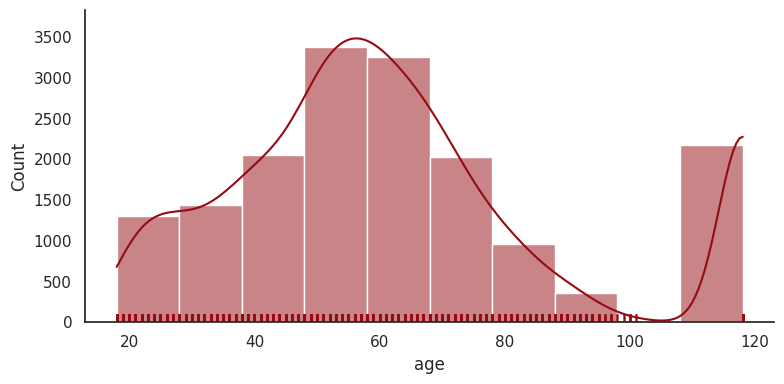

In [0]:
sns.displot(customers_pdf['age'], height=4, aspect=2, kind='hist', rug=True, bins=10, kde=True);

<Axes: xlabel='gender', ylabel='age'>

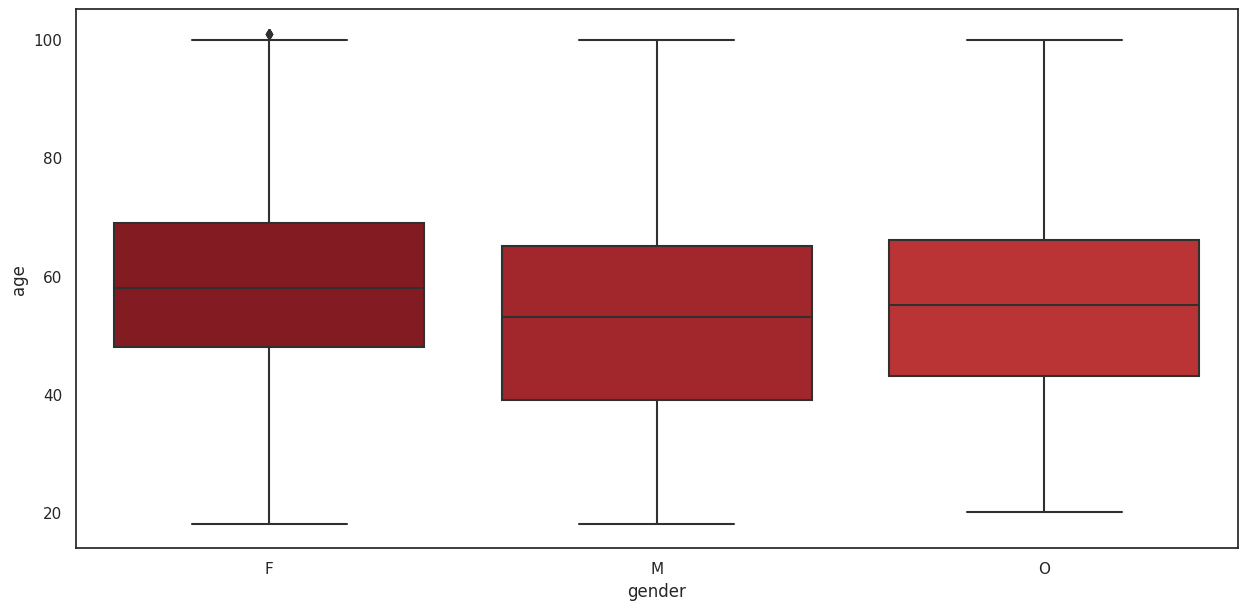

In [0]:
sns.boxplot(x="gender", y="age", data=customers_pdf)

In [0]:
prop_gender = pd.crosstab(index=customers_pdf['gender'], columns='count')
prop_gender/prop_gender.sum()

col_0      count
gender          
F       0.413423
M       0.572277
O       0.014300

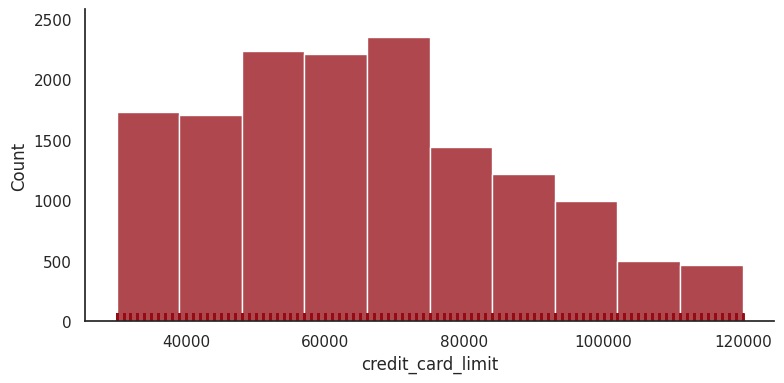

In [0]:
sns.displot(customers_pdf['credit_card_limit'], height=4, aspect=2, kind='hist', rug=True, bins=10)

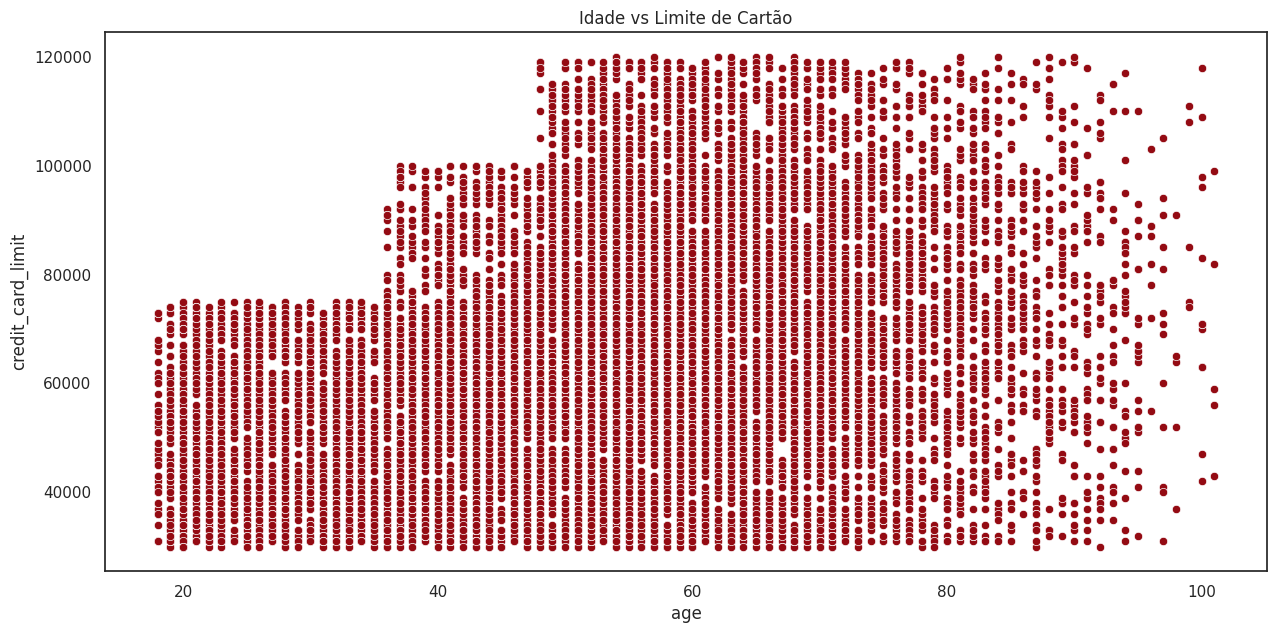

In [0]:
sns.scatterplot(x="age", y="credit_card_limit", data=customers_pdf)
plt.title("Idade vs Limite de Cartão")
plt.show()

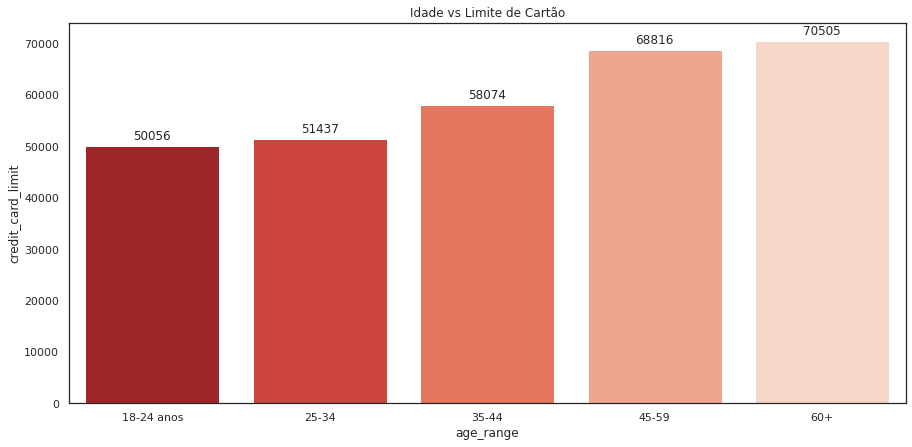

In [0]:
age_credit_df = customers_pdf.groupby("age_range")["credit_card_limit"].mean().round(2).reset_index()

ax = sns.barplot(x="age_range", y="credit_card_limit", data=age_credit_df)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
plt.title("Idade vs Limite de Cartão")
plt.show()

In [0]:
subset = customers_pdf[['age', 'credit_card_limit', 'gender']].dropna()
corr_coef, p_value = pearsonr(subset['age'], subset['credit_card_limit'])

print(f"Coeficiente de Pearson: {corr_coef:.4f}")
print(f"P-valor: {p_value:.4f}")

Coeficiente de Pearson: 0.3067
P-valor: 0.0000


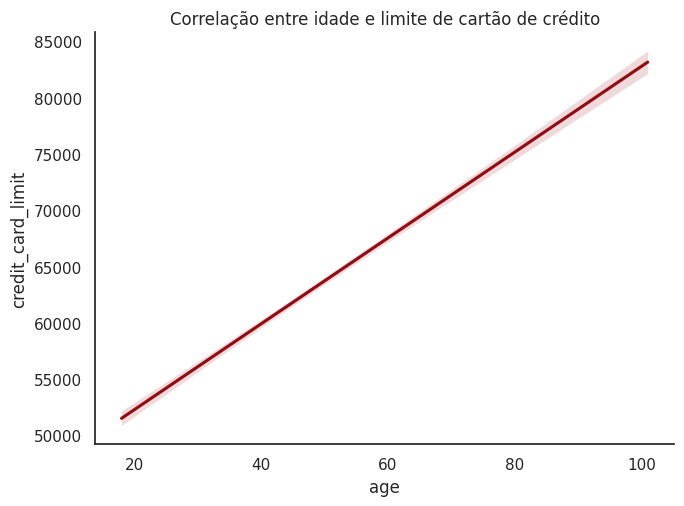

In [0]:
sns.lmplot(x='age', y='credit_card_limit', data=customers_pdf, aspect=1.4, scatter=False)
plt.title("Correlação entre idade e limite de cartão de crédito")
plt.show()

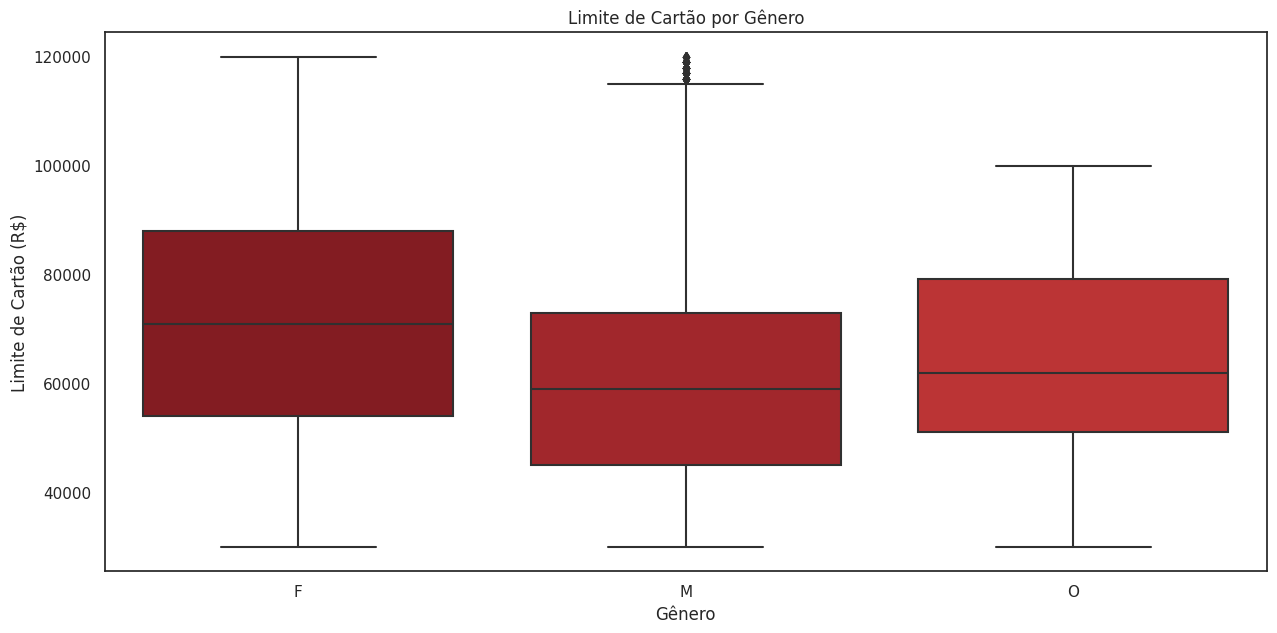

In [0]:
sns.boxplot(x="gender", y="credit_card_limit", data=customers_pdf)
plt.title("Limite de Cartão por Gênero")
plt.ylabel("Limite de Cartão (R$)")
plt.xlabel("Gênero")
plt.show()

### Outliers idade

In [0]:
customers_df.filter(f.col("age")>100).count()
#12.8% das amostras apresentam idade acima de 100 anos

2180

In [0]:
customers_age_outliers = customers_df.filter(f.col("age") > 100)
customers_age_outliers.describe().show()

+-------+------------------+------------------+------+--------------------+--------------------+
|summary|               age| credit_card_limit|gender|                  id|       registered_on|
+-------+------------------+------------------+------+--------------------+--------------------+
|  count|              2180|                 5|     5|                2180|                2180|
|   mean|117.96100917431193|           67800.0|  NULL|                NULL|2.0168033980733946E7|
| stddev|0.8134047276407826|22398.660674245682|  NULL|                NULL|  10087.193141670776|
|    min|               101|           43000.0|     F|00116118485d4dfda...|            20130802|
|    max|               118|           99000.0|     F|ffede3b700ac41d6a...|            20180726|
+-------+------------------+------------------+------+--------------------+--------------------+



In [0]:
count_gender_age_outliers = (
    customers_age_outliers.groupBy("gender")
    .agg(f.count("*").alias("count"))
)

total = count_gender_age_outliers.agg({"count": "sum"}).collect()[0][0]

count_gender_age_outliers.withColumn("proporcao", f.round(f.col("count") / total, 4)).show()

+------+-----+---------+
|gender|count|proporcao|
+------+-----+---------+
|  NULL| 2175|   0.9977|
|     F|    5|   0.0023|
+------+-----+---------+



In [0]:
customers_age_outliers.filter(f.col("gender").isNotNull()).show()

+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|101|          43000.0|     F|4d2ccfcbbebf4bd9b...|     20171004|
|101|          99000.0|     F|d2fdc2be8ab64e4ba...|     20150526|
|101|          56000.0|     F|e0ea90ddd2f147e08...|     20171109|
|101|          59000.0|     F|047ad0135cfe4c0ea...|     20170309|
|101|          82000.0|     F|1593d617fac246ef8...|     20171127|
+---+-----------------+------+--------------------+-------------+



In [0]:
customers_age_outliers.filter(f.col("gender").isNull()).show()

+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|118|             NULL|  NULL|68be06ca386d4c319...|     20170212|
|118|             NULL|  NULL|38fe809add3b4fcf9...|     20180712|
|118|             NULL|  NULL|a03223e636434f42a...|     20170804|
|118|             NULL|  NULL|8ec6ce2a7e7949b1b...|     20170925|
|118|             NULL|  NULL|68617ca6246f4fbc8...|     20171002|
|118|             NULL|  NULL|8974fc5686fe429db...|     20161122|
|118|             NULL|  NULL|c4863c7985cf408fa...|     20170824|
|118|             NULL|  NULL|148adfcaa27d485b8...|     20150919|
|118|             NULL|  NULL|744d603ef08c4f33a...|     20170801|
|118|             NULL|  NULL|2b826eba31074a059...|     20170907|
|118|             NULL|  NULL|65aba5c617294649a...|     20170330|
|118|             NULL|  NULL|4beeb3ed64dd4898b...|     20160707|
|118|     

In [0]:
cust_pd = customers_df.select("age", "credit_card_limit", "gender").dropna().toPandas()

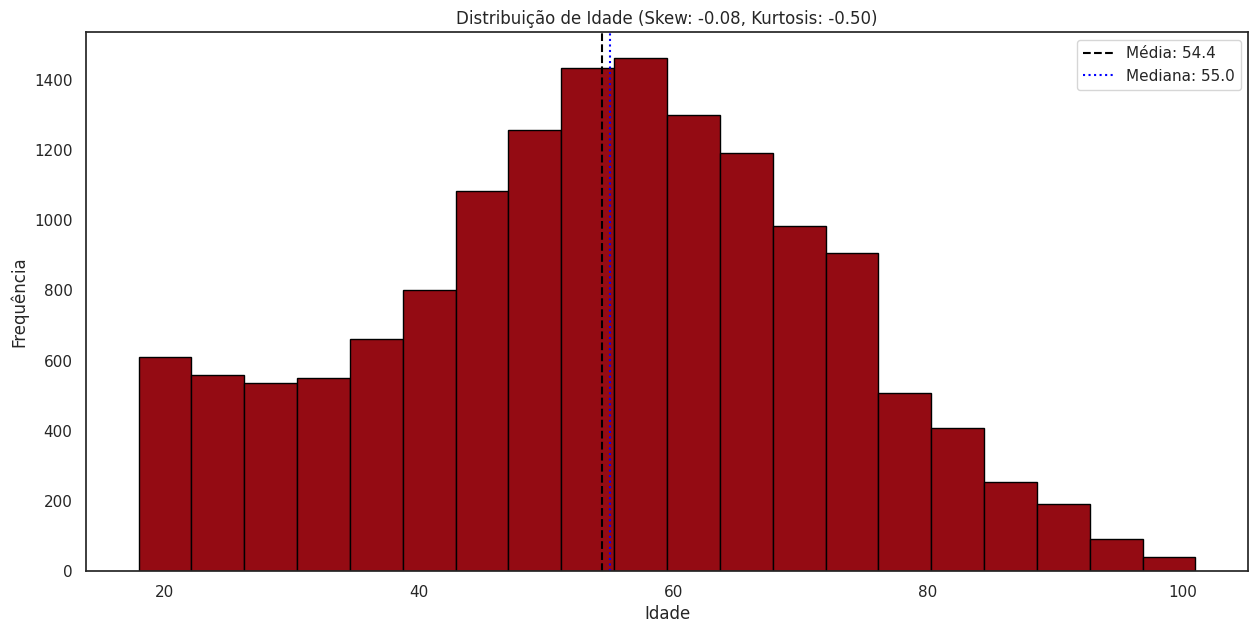

In [0]:
from scipy.stats import skew, kurtosis

mean_age = cust_pd["age"].mean()
median_age = cust_pd["age"].median()
sk = skew(cust_pd["age"])
kt = kurtosis(cust_pd["age"])

plt.hist(cust_pd["age"], bins=20, edgecolor='black')
plt.axvline(mean_age, color='black', linestyle='dashed', label=f'Média: {mean_age:.1f}')
plt.axvline(median_age, color='blue', linestyle='dotted', label=f'Mediana: {median_age:.1f}')
plt.title(f"Distribuição de Idade (Skew: {sk:.2f}, Kurtosis: {kt:.2f})")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.legend()
plt.show()

# skewness = -.08 -> A distribuição da idade é aproximadamente simétrica, indicando que valores baixos e altos estão balanceados em torno da média. # kurtosis = -.50 -> A curtose ligeiramente negativa sugere que a distribuição tem menos valores extremos do que uma normal, sendo mais uniforme ao redor da média.

## Transacões

In [0]:
transactions_df.display()

account_id event time_since_test_start value 78afa995795e4d85b5d9ceeca43f5fef offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) a03223e636434f42ac4c3df47e8bac43 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) e2127556f4f64592b11af22de27a7932 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null, null) 8ec6ce2a7e7949b1bf142def7d0e0586 offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null, null) 68617ca6246f4fbc85e91a2a49552598 offer received 0.0 List(null, 4d5c57ea9a6940dd891ad53e9dbe8da0, null, null) 389bc3fa690240e798340f5a15918d5c offer received 0.0 List(null, f19421c1d4aa40978ebb69ca19b0e20d, null, null) c4863c7985cf408faee930f111475da3 offer received 0.0 List(null, 2298d6c36e964ae4a3e7e9706d1fb8c2, null, null) 2eeac8d8feae4a8cad5a6af0499a211d offer received 0.0 List(null, 3f207df678b143eea3cee63160fa8bed, null, null) aa4862eba776480b8bb9c68455b8c2e1 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) 31dda685af34476cad5bc968bdb01c53 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) 744d603ef08c4f33af5a61c8c7628d1c offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) 3d02345581554e81b7b289ab5e288078 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) 4b0da7e80e5945209a1fdddfe813dbe0 offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null, null) c27e0d6ab72c455a8bb66d980963de60 offer received 0.0 List(null, 3f207df678b143eea3cee63160fa8bed, null, null) d53717f5400c4e84affdaeda9dd926b3 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) f806632c011441378d4646567f357a21 offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null, null) d058f73bf8674a26a95227db098147b1 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) 65aba5c617294649aeb624da249e1ee5 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null, null) ebe7ef46ea6f4963a7dd49f501b26779 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) 1e9420836d554513ab90eba98552d0a9 offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null, null) 868317b9be554cb18e50bc68484749a2 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null, null) f082d80f0aac47a99173ba8ef8fc1909 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) 102e9454054946fda62242d2e176fdce offer received 0.0 List(null, 4d5c57ea9a6940dd891ad53e9dbe8da0, null, null) 4beeb3ed64dd4898b0edf2f6b67426d3 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null, null) 9f30b375d7bd4c62a884ffe7034e09ee offer received 0.0 List(null, 2298d6c36e964ae4a3e7e9706d1fb8c2, null, null) 25c906289d154b66bf579693f89481c9 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null, null) 6e014185620b49bd98749f728747572f offer received 0.0 List(null, f19421c1d4aa40978ebb69ca19b0e20d, null, null) 02c083884c7d45b39cc68e1314fec56c offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null, null) c0d210398dee4a0895b24444a5fcd1d2 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) 8be4463721e14d7fa600686bf8c8b2ed offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null, null) 57dd18ec5ddc46828afb81ec5977bef2 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) be8a5d1981a2458d90b255ddc7e0d174 offer received 0.0 List(null, 5a8bc65990b245e5a138643cd4eb9837, null, null) a3b9b4bf115e4564933ea2e4bc936843 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) 7584948ea6d04f94b8798624706261c2 offer received 0.0 List(null, 4d5c57ea9a6940dd891ad53e9dbe8da0, null, null) 9c64321646bf40f6ad1bc98864eaa6b8 offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null, null) 676506bad68e4161b9bbaffeb039626b offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null, null) 9fa9ae8f57894cc9a3b8a9bbe0fc1b2

In [0]:
transactions_df.groupBy("event").count().display()

event count offer received 76277 offer viewed 57725 offer completed 33579 transaction 138953

In [0]:
transactions_df.select(
    f.col("event"),
    f.col("value.`offer id`").alias("com_espaco"),
    f.col("value.offer_id").alias("com_underline")
).groupBy("event").agg(
    f.count("com_espaco").alias("of_id_espaco"),
    f.count("com_underline").alias("of_id_underline")
).display()

event of_id_espaco of_id_underline offer received 76277 0 offer viewed 57725 0 offer completed 0 33579 transaction 0 0

In [0]:
processed_transactions_df = (
    transactions_df.withColumn("amount", f.col("value.amount"))
    .withColumn("offer_id_space", f.col("value.offer id"))
    .withColumn("offer_id_undeline", f.col("value.offer_id"))
    .withColumn("offer_id", 
                f.when(
                    f.col("offer_id_space").isNotNull(), f.col("offer_id_space"))
                .otherwise(f.col("offer_id_undeline")))
    .withColumn("reward", f.col("value.reward"))
    .drop("value", "offer_id_space", "offer_id_undeline")
    .fillna(0)
)

In [0]:
processed_transactions_df.groupBy("event").agg(
    f.count("offer_id").alias("count_offer_id"),
    f.count("reward").alias("count_reward"),
    f.sum("reward").alias("sum_reward"),
    f.round(f.sum("amount").alias("sum_amount"), 2).alias("sum_amount")
).display()

event count_offer_id count_reward sum_reward sum_amount transaction 0 138953 0.0 1775451.97 offer received 76277 76277 0.0 0.0 offer completed 33579 33579 164676.0 0.0 offer viewed 57725 57725 0.0 0.0

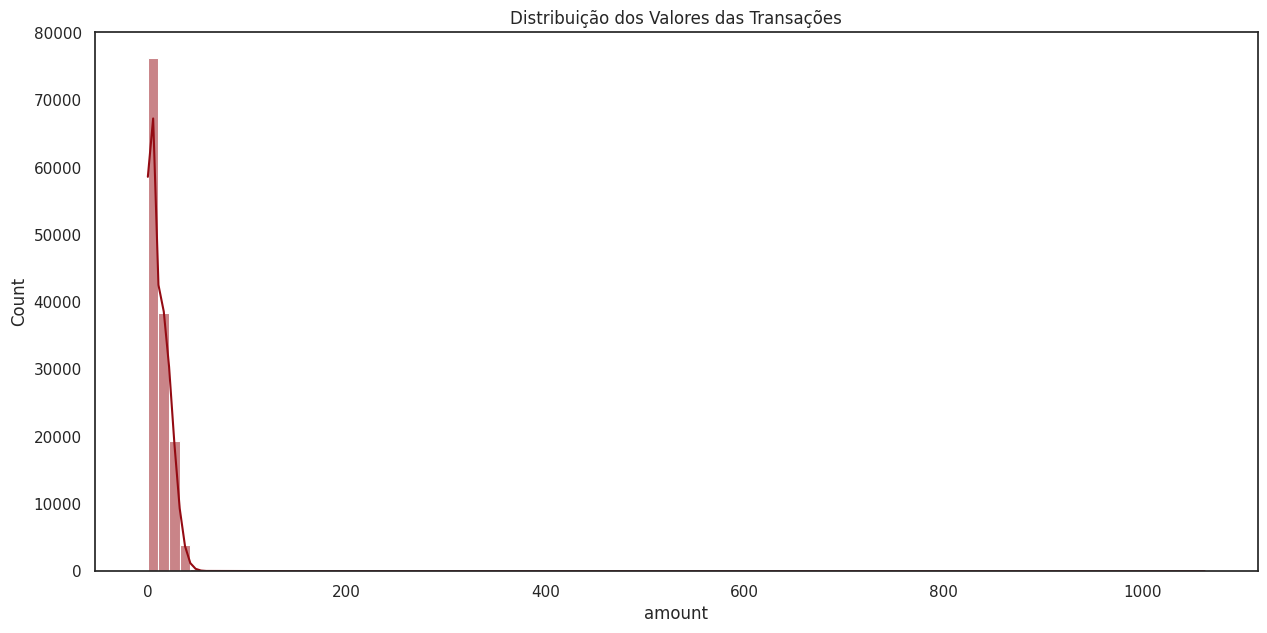

In [0]:
amount_transaction_pdf = (
    processed_transactions_df.filter(f.col("event") == "transaction")
    .select("amount").toPandas()
)

sns.histplot(amount_transaction_pdf["amount"], bins=100, kde=True)
plt.title("Distribuição dos Valores das Transações")
plt.show()


## Junção de datasets Transactions e Offers

In [0]:
offers_df = offers_df.withColumnRenamed("id", "offer_id")
offers_transactions_df = processed_transactions_df.join(offers_df, "offer_id", "left")
offers_transactions_df.show(5)

+--------------------+--------------------+--------------+---------------------+------+------+--------------------+--------------+--------+---------+----------+
|            offer_id|          account_id|         event|time_since_test_start|amount|reward|            channels|discount_value|duration|min_value|offer_type|
+--------------------+--------------------+--------------+---------------------+------+------+--------------------+--------------+--------+---------+----------+
|9b98b8c7a33c4b65b...|78afa995795e4d85b...|offer received|                  0.0|   0.0|   0.0|[web, email, mobile]|             5|     7.0|        5|      bogo|
|0b1e1539f2cc45b7b...|a03223e636434f42a...|offer received|                  0.0|   0.0|   0.0|        [web, email]|             5|    10.0|       20|  discount|
|2906b810c7d441179...|e2127556f4f64592b...|offer received|                  0.0|   0.0|   0.0|[web, email, mobile]|             2|     7.0|       10|  discount|
|fafdcd668e3743c1b...|8ec6ce2a7e79

In [0]:
offers_status = (
    offers_transactions_df.select("account_id", "offer_id", "event")
    .filter(f.col("event").isin(
        "offer received", "offer viewed", "offer completed"))
    .groupBy("account_id", "offer_id")
    .pivot("event", ["offer received", "offer viewed", "offer completed"])
    .agg(f.count("event"))
)

offers_status_type = offers_status.join(
    offers_df.select("offer_id", "offer_type"), on="offer_id")

metrics_offers_status_type = (
    offers_status_type.groupBy("offer_type").agg(
        f.sum("offer received").alias("total_offer_received"),
        f.sum("offer viewed").alias("total_offer_viewed"),
        f.sum("offer completed").alias("total_offer_completed"),
        f.round(100*(f.sum("offer completed")/f.sum("offer received")),3).alias("conversion_rate"),
        f.round(100*(f.sum("offer viewed")/f.sum("offer received")),3).alias("ctr")
    ).fillna(0).toPandas()
)

In [0]:
(offers_status.filter(
    (f.col("offer_id")!="5a8bc65990b245e5a138643cd4eb9837")
    & (f.col("offer_id")!="3f207df678b143eea3cee63160fa8bed")
)
 .groupBy("offer_id")
 .agg(
    f.round(100*(f.sum("offer completed")/f.sum("offer received")),2).alias("conversion_rate")
)
 .select(f.mean("conversion_rate"))
 .display()
)

avg(conversion_rate) 55.01625000000001

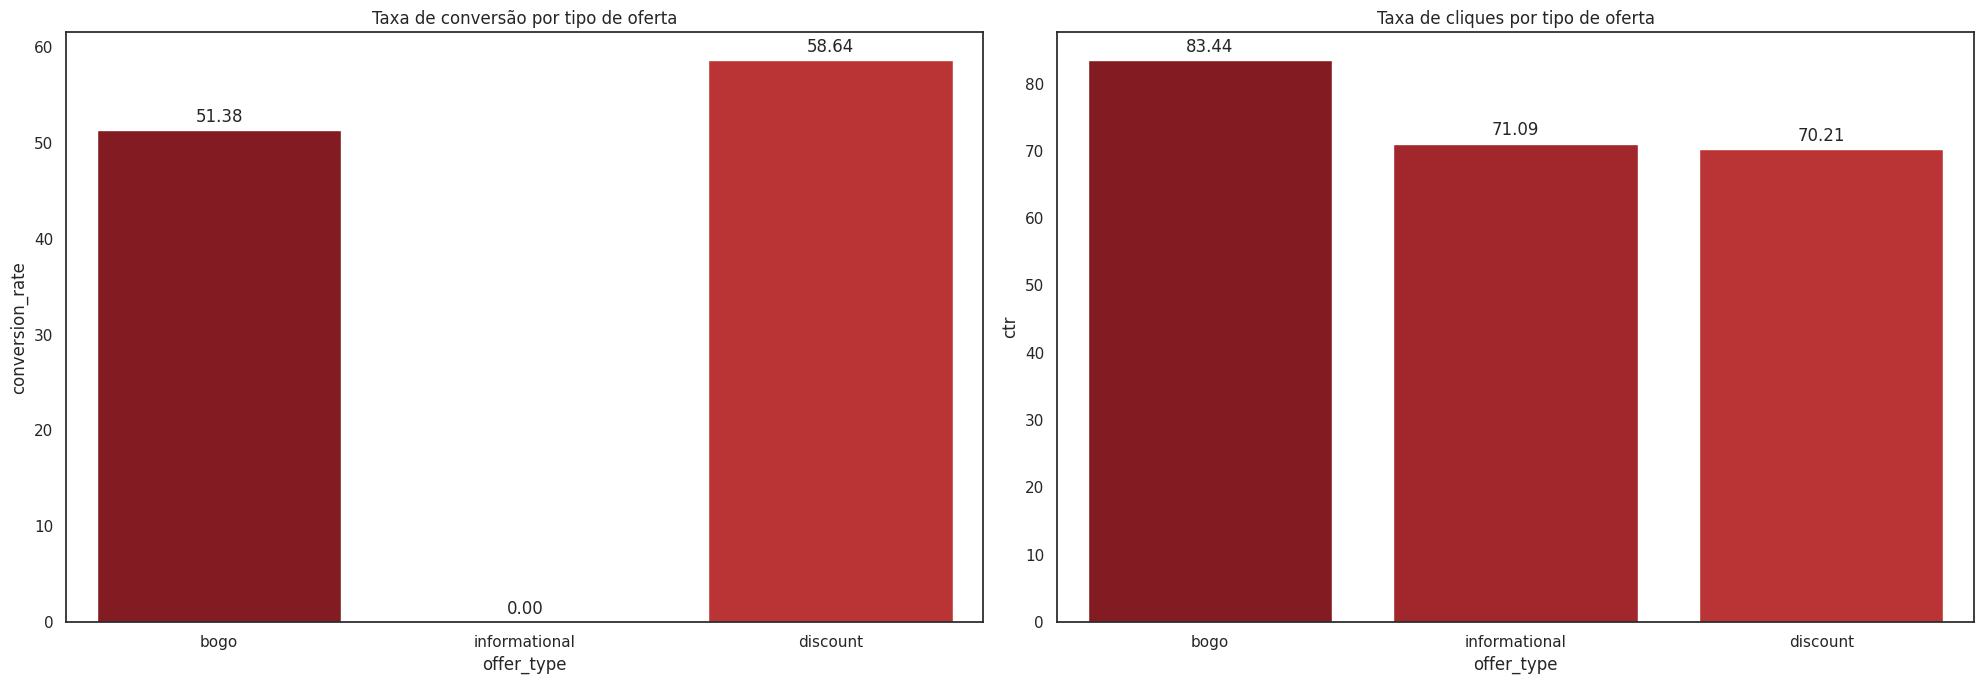

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

sns.barplot(x="offer_type", y="conversion_rate", data=metrics_offers_status_type, ax=axes[0])
axes[0].set_title("Taxa de conversão por tipo de oferta")

for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", padding=3)

sns.barplot(x="offer_type", y="ctr", data=metrics_offers_status_type, ax=axes[1])
axes[1].set_title("Taxa de cliques por tipo de oferta")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f", padding=3)

plt.tight_layout()
plt.show()

In [0]:
(offers_transactions_df.filter(f.col("event") == "transaction") 
.groupBy("event") 
.agg(f.round(f.mean("amount"),2).alias("amount_mean"), 
     f.round(f.stddev("amount"),2).alias("amount_std"))
.show()) 

+-----------+-----------+----------+
|      event|amount_mean|amount_std|
+-----------+-----------+----------+
|transaction|      12.78|     30.25|
+-----------+-----------+----------+



In [0]:
pivot_funil = (
    offers_transactions_df.groupBy(
        "account_id", "offer_id", "offer_type", "min_value",
        "reward", "discount_value", "duration"
    ).pivot("event", ["offer received", "offer viewed", "offer completed"]) 
    .agg(f.count("account_id"))
    .fillna(0)
)

In [0]:
(pivot_funil.groupBy("account_id")
 .agg(
    f.countDistinct("offer_id").alias("count_offers"))
 .select(f.min("count_offers"), f.max("count_offers"), f.mean("count_offers"))
 .display())

min(count_offers) max(count_offers) avg(count_offers) 0 6 3.7228235294117646

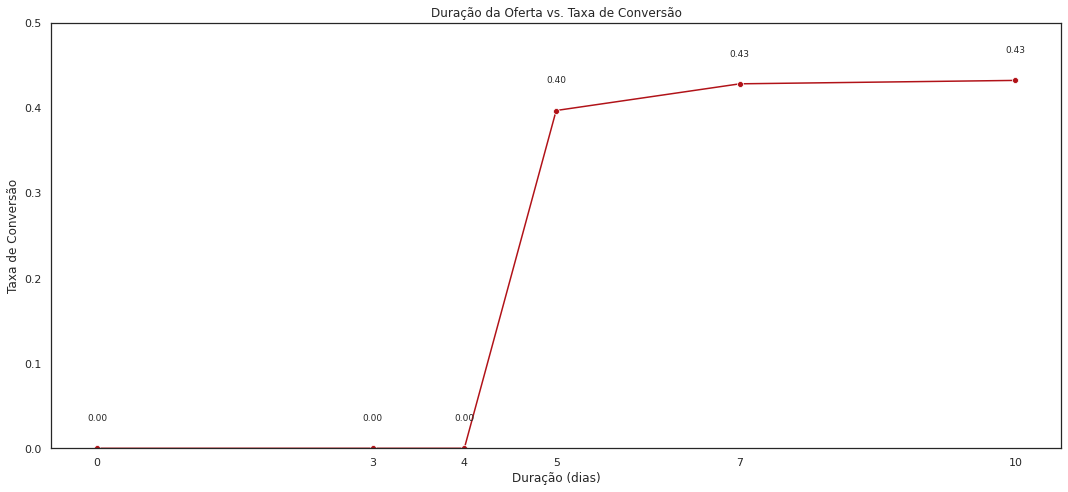

In [0]:
duration_conv = (
    pivot_funil.toPandas()
    .groupby("duration")["offer completed"].mean()
    .reset_index())

ax = sns.lineplot(
    data=duration_conv,
    x="duration",
    y="offer completed",
    marker="o"
)
plt.title("Duração da Oferta vs. Taxa de Conversão")
plt.xlabel("Duração (dias)")
plt.ylabel("Taxa de Conversão")
plt.ylim(0, 0.5)
plt.xticks(duration_conv["duration"])

for i in range(len(duration_conv)):
    x = duration_conv["duration"][i]
    y = duration_conv["offer completed"][i]
    ax.text(x, y + 0.03, f"{y:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [0]:
min_value_status = (
    pivot_funil.groupBy("completed")
    .agg(
        f.count("*").alias("num_amostras"),
        f.avg("min_value").alias("avg_min_value"),
        f.stddev("min_value").alias("std_min_value")
    )
    .toPandas()
)

rewards_status = (
    pivot_funil.groupBy("completed")
    .agg(
        f.count("*").alias("num_amostras"),
        f.avg("reward").alias("avg_reward"),
        f.stddev("reward").alias("std_reward")
    )
    .toPandas()
)  

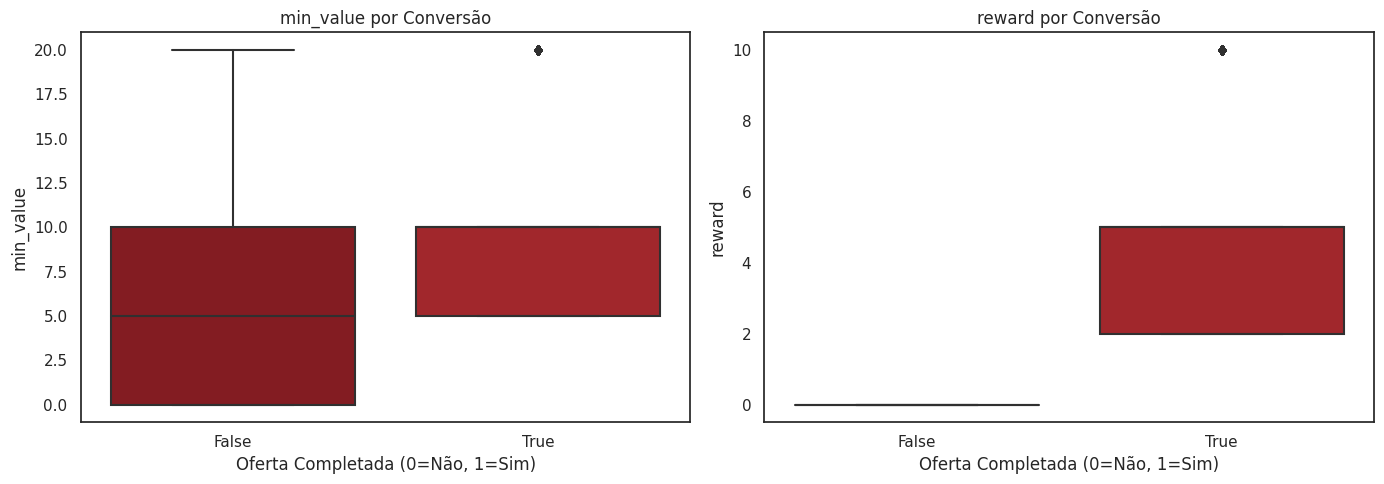

In [0]:
pivot_pd = pivot_funil.select(
    "completed", "min_value", "reward").toPandas()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot min_value
sns.boxplot(x="completed", y="min_value", data=pivot_pd, ax=ax[0])
ax[0].set_title("min_value por Conversão")
ax[0].set_xlabel("Oferta Completada (0=Não, 1=Sim)")
ax[0].set_ylabel("min_value")

# Boxplot reward
sns.boxplot(x="completed", y="reward", data=pivot_pd, ax=ax[1])
ax[1].set_title("reward por Conversão")
ax[1].set_xlabel("Oferta Completada (0=Não, 1=Sim)")
ax[1].set_ylabel("reward")

plt.tight_layout()
plt.show()

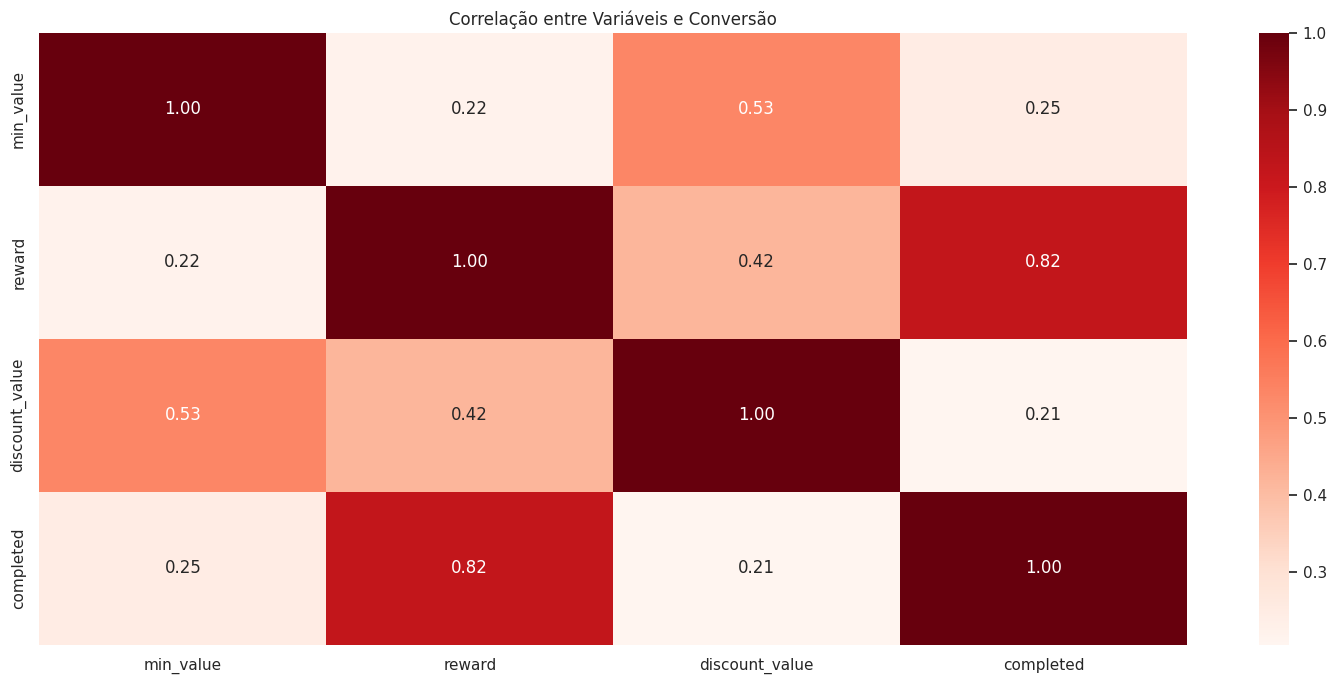

In [0]:
# Correlações usando método nativo de PySpark
pivot_funil = pivot_funil.withColumn("completed", f.col("completed").cast("int"))
corr_min = pivot_funil.stat.corr("min_value", "completed")
corr_reward = pivot_funil.stat.corr("reward", "completed")
corr_discount = pivot_funil.stat.corr("discount_value", "completed")

# Converte apenas as colunas necessárias
cols = ["min_value", "reward", "discount_value", "completed"]
pivot_corr_pd = pivot_funil.select(cols).toPandas()

sns.heatmap(pivot_corr_pd.corr(), annot=True, cmap="Reds", fmt=".2f")
plt.title("Correlação entre Variáveis e Conversão")
plt.tight_layout()
plt.show()

## Junção de datasets Transactions, Offers e Consumers

In [0]:
from pyspark.sql.types import DateType

customers_df = (
    customers_df.withColumnRenamed("id", "account_id")
    .withColumn("registered_on", f.to_date("registered_on", "yyyyMMdd"))
)

customers_df.display()

age credit_card_limit gender account_id registered_on 118 null null 68be06ca386d4c31939f3a4f0e3dd783 2017-02-12 55 112000.0 F 0610b486422d4921ae7d2bf64640c50b 2017-07-15 118 null null 38fe809add3b4fcf9315a9694bb96ff5 2018-07-12 75 100000.0 F 78afa995795e4d85b5d9ceeca43f5fef 2017-05-09 118 null null a03223e636434f42ac4c3df47e8bac43 2017-08-04 68 70000.0 M e2127556f4f64592b11af22de27a7932 2018-04-26 118 null null 8ec6ce2a7e7949b1bf142def7d0e0586 2017-09-25 118 null null 68617ca6246f4fbc85e91a2a49552598 2017-10-02 65 53000.0 M 389bc3fa690240e798340f5a15918d5c 2018-02-09 118 null null 8974fc5686fe429db53ddde067b88302 2016-11-22 118 null null c4863c7985cf408faee930f111475da3 2017-08-24 118 null null 148adfcaa27d485b82f323aaaad036bd 2015-09-19 58 51000.0 M 2eeac8d8feae4a8cad5a6af0499a211d 2017-11-11 61 57000.0 F aa4862eba776480b8bb9c68455b8c2e1 2017-09-11 26 46000.0 M e12aeaf2d47d42479ea1c4ac3d8286c6 2014-02-13 62 71000.0 F 31dda685af34476cad5bc968bdb01c53 2016-02-11 49 52000.0 M 62cf5e10845442329191fc246e7bcea3 2014-11-13 118 null null 744d603ef08c4f33af5a61c8c7628d1c 2017-08-01 57 42000.0 M 6445de3b47274c759400cd68131d91b4 2017-12-31 61 40000.0 F a448667f336b42c9a66fc5ffd5d73772 2018-05-01 40 71000.0 F 440cf1fd7580490c971d8c651ed962af 2016-05-04 64 100000.0 M 4b0da7e80e5945209a1fdddfe813dbe0 2017-09-09 78 71000.0 F c27e0d6ab72c455a8bb66d980963de60 2017-06-16 118 null null 2b826eba31074a059d63b0ae8f50b7d5 2017-09-07 42 69000.0 M f806632c011441378d4646567f357a21 2013-08-11 56 88000.0 F d058f73bf8674a26a95227db098147b1 2018-04-28 118 null null 65aba5c617294649aeb624da249e1ee5 2017-03-30 33 52000.0 F c6c9884912c645429f3333f912b55f44 2017-09-26 46 59000.0 F 7429a044884842d6862f516c38b1156f 2017-09-11 59 41000.0 M ebe7ef46ea6f4963a7dd49f501b26779 2015-01-21 67 96000.0 M 5917d13f6fa04286abdf95f4d5cefb1e 2014-08-23 53 52000.0 O d1ede868e29245ea91818a903fec04c6 2017-09-16 22 70000.0 M 1e9420836d554513ab90eba98552d0a9 2017-09-25 96 89000.0 F 868317b9be554cb18e50bc68484749a2 2017-11-17 40 33000.0 M f082d80f0aac47a99173ba8ef8fc1909 2016-07-09 69 57000.0 F 102e9454054946fda62242d2e176fdce 2016-08-14 118 null null 4beeb3ed64dd4898b0edf2f6b67426d3 2016-07-07 56 68000.0 M 8dabe2142cdf4013a6f4786edf8ab00f 2014-05-11 26 63000.0 F 9f30b375d7bd4c62a884ffe7034e09ee 2017-08-12 118 null null 25c906289d154b66bf579693f89481c9 2018-01-13 75 40000.0 M 6e014185620b49bd98749f728747572f 2015-11-12 20 30000.0 F 02c083884c7d45b39cc68e1314fec56c 2016-07-11 45 33000.0 M c0d210398dee4a0895b24444a5fcd1d2 2018-07-07 61 98000.0 M 8b70ca1f5f5a45bdac2ac2f990b71526 2017-11-21 118 null null 5b8f1f0e0930464f93bb55e59b5a04e0 2014-11-11 118 null null 8be4463721e14d7fa600686bf8c8b2ed 2017-05-11 69 37000.0 F 8e7c7465e98c43d8a01f51e2b5c29542 2013-09-18 54 80000.0 F 57dd18ec5ddc46828afb81ec5977bef2 2017-02-07 39 51000.0 M be8a5d1981a2458d90b255ddc7e0d174 2014-05-27 41 41000.0 F 3f89b8f80ebc4f94b7074f28071aa8d4 2015-09-21 79 48000.0 F a3b9b4bf115e4564933ea2e4bc936843 2015-04-15 66 38000.0 F 7584948ea6d04f94b8798624706261c2 2018-04-08 56 52000.0 F e9844d5beac04bf8b8d3ad18f7e37fca 2017-06-26 39 56000.0 F f247806381704ea58c1b06f60602a6ae 2014-07-23 118 null null 81ac76e4f2fe4a6bb5ebdc0f19cecc56 2017-05-28 42 96000.0 M 9fa9ae8f57894cc9a3b8a9bbe0fc1b2f 2016-01-17 118 null null 020d3a52b9ce432ea5f98fc58e9bfcc4 2017-10-13 118 null null 4be1127413db496d8103c783ae72058b 2015-12-20 78 93000.0 F fe8264108d5b4f198453bbb1fa7ca6c9 2016-10-09 45 48000.0 M 186d6403f5824c739555b732f4af3f16 2017-10-06 29 50000.0 M 8a87fda1a6644337b4394a4c3cd0946c 2016-04-30 44 35000.0 M b7a66e629b134079a9bc7120c7b9947b 2017-09-24 63 56000.0 M ca82e1ebc759402c8ab95c341755bdf1 2018-07-13 36 56000.0 M 54890f68699049c2a04d415abc25e717 2017-12-28 76 47000.0 F ab66a363907e43e9a7cd535f1578245b 2018-03-14 68 87000.0 M d3f146b615514c6380b168bb3df5f05b 2017-08-23 75 52000.0 M a5a6ef2b78a04ddc9f374dd7c7f60bff 2015-11-29 67 76000.0 M 2e87ba0fba1a4d1a8614af771f07a94d 2017-02-26 77 51000.0 M d8af520c4a8a4c77b921098d7d838c4d 201

In [0]:
customers_df.select(f.min("registered_on"), f.max("registered_on")).show()

+------------------+------------------+
|min(registered_on)|max(registered_on)|
+------------------+------------------+
|        2013-07-29|        2018-07-26|
+------------------+------------------+



In [0]:
data_baseline = f.lit("2018-07-26")

account_age_df = (
    customers_df.withColumn(
        "days_since_registration", f.datediff(data_baseline, "registered_on"))
    .withColumn(
        "account_age_status", 
        f.when(f.col("days_since_registration") <= 30, "0-30 dias")
        .when(f.col("days_since_registration") <= 90, "31-90 dias")
        .when(f.col("days_since_registration") <= 365, "91-365 dias")
        .when(f.col("days_since_registration") <= 730, "1-2 anos")
        .otherwise("2+ anos")
    )
    .select("account_age_status", "days_since_registration", "account_id")
    .join(pivot_funil, "account_id", "inner")
    .withColumn("completed", f.col("offer completed").cast("int"))
)

In [0]:
(account_age_df.filter(f.col("offer received")==1)
 .groupBy("age_range")
 .agg(f.countDistinct("account_id"))
 .display())

age_range count(account_id) 18-24 anos 859 60+ 7882 35-44 1833 25-34 1353 45-59 4732

In [0]:
(account_age_df.filter(f.col("completed")==1)
 .groupBy("age_range")
 .agg(f.countDistinct("account_id"))
 .display())

age_range count(account_id) 18-24 anos 566 60+ 5424 35-44 1388 25-34 937 45-59 3809

In [0]:
(account_age_df.filter(f.col("offer completed")==1)
 .groupBy("age_range", "offer_type")
 .agg(f.count("account_id"))
 .display())

age_range offer_type count(account_id) 45-59 bogo 3888 25-34 bogo 852 60+ bogo 5077 18-24 anos bogo 486 18-24 anos discount 605 35-44 discount 1514 35-44 bogo 1374 45-59 discount 4180 60+ discount 5831 25-34 discount 986

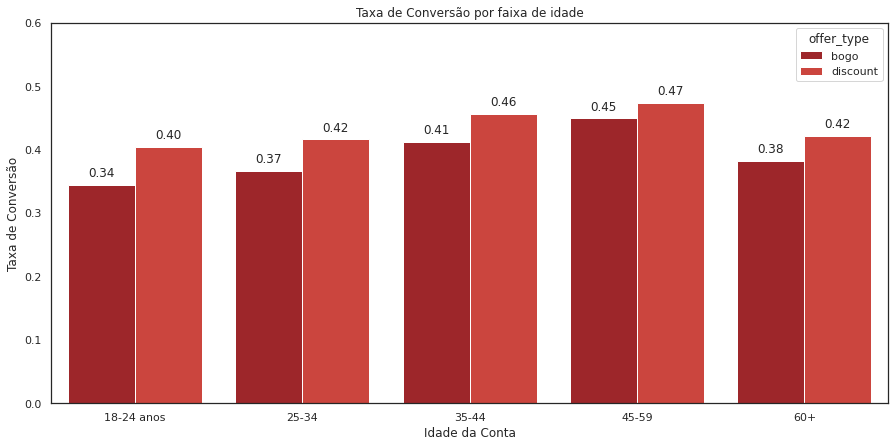

In [0]:
conv_account_age = (
    account_age_df.groupBy("age_range", "offer_type")
    .agg(
        f.count("*").alias("total"),
        f.expr("sum(completed) / count(*)").alias("conv_rate")
    )
    .filter(f.col("offer_type").isin("bogo", "discount"))
    .orderBy("age_range")
    .toPandas()
)

ax= sns.barplot(data=conv_account_age, x="age_range", y="conv_rate", hue="offer_type")
plt.title("Taxa de Conversão por faixa de idade")
plt.xlabel("Idade da Conta")
plt.ylabel("Taxa de Conversão")
plt.ylim(0, 0.6)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=5)
plt.show()  

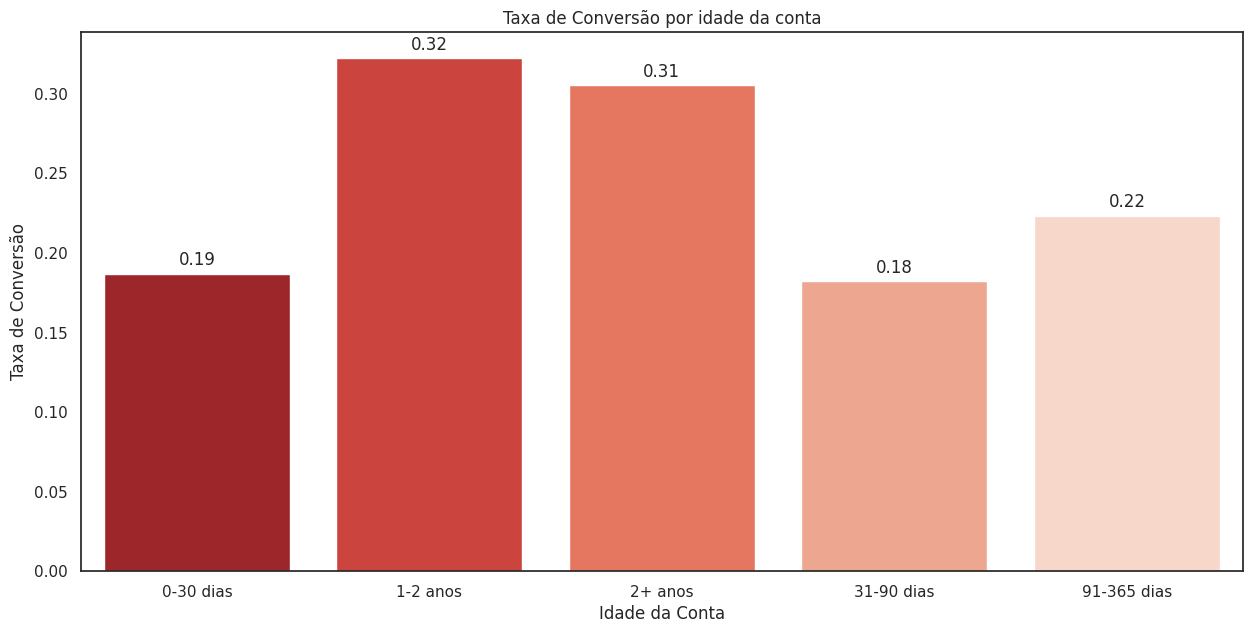

In [0]:
conv_account_age = (
    account_age_df.groupBy("account_age_status")
    .agg(
        f.count("*").alias("total"),
        f.expr("sum(completed) / count(*)").alias("conv_rate")
    )
    .orderBy("account_age_status")
    .toPandas()
)

ax= sns.barplot(data=conv_account_age, x="account_age_status", y="conv_rate")
plt.title("Taxa de Conversão por idade da conta")
plt.xlabel("Idade da Conta")
plt.ylabel("Taxa de Conversão")
#plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)
plt.show()  

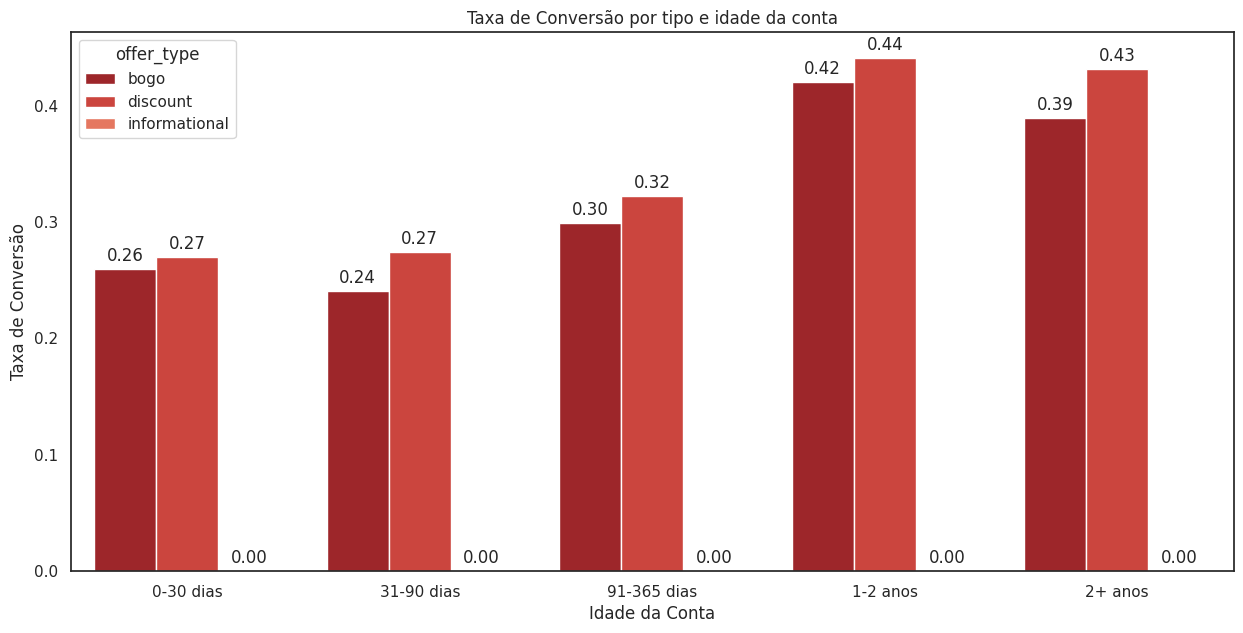

In [0]:
conv_segmentada = (
    account_age_df.groupBy("account_age_status", "offer_type").agg(
    f.count("*").alias("total"),
    f.expr("sum(completed) / count(*)").alias("conv_rate")
    )
    .orderBy("account_age_status", "offer_type")
    .toPandas())

age_account_order = ["0-30 dias", "31-90 dias", "91-365 dias", "1-2 anos", "2+ anos"]
ax= sns.barplot(data=conv_segmentada, x="account_age_status", y="conv_rate", 
                hue="offer_type", order=age_account_order)
plt.title("Taxa de Conversão por tipo e idade da conta")
plt.xlabel("Idade da Conta")
plt.ylabel("Taxa de Conversão")
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)
plt.show()  

In [0]:
customer_offers_transactions_df = offers_transactions_df.join(customers_df, "account_id", "left")

In [0]:
customer_offers_transactions_df.filter(
    (f.col("event").isin("completed", "transaction"))
    & (f.col("gender").isNull())
    & (f.col("credit_card_limit").isNull())
).select("account_id").distinct().count()

2086

# Data Prep

In [0]:
offers_df = offers_df.withColumnRenamed("id", "offer_id")

processed_transactions_df = (
    transactions_df.withColumn("amount", f.col("value.amount"))
    .withColumn("offer_id_space", f.col("value.offer id"))
    .withColumn("offer_id_undeline", f.col("value.offer_id"))
    .withColumn("offer_id", 
                f.when(
                    f.col("offer_id_space").isNotNull(), f.col("offer_id_space"))
                .otherwise(f.col("offer_id_undeline")))
    .withColumn("reward", f.col("value.reward"))
    .drop("value", "offer_id_space", "offer_id_undeline")
)

offers_transactions_df = processed_transactions_df.join(offers_df, "offer_id", "left")

In [0]:
pivot_funil = (
    offers_transactions_df.groupBy(
        "account_id", "offer_id", "offer_type", "min_value",
        "reward", "discount_value", "duration", "amount"
    ).pivot("event") 
    .agg(f.count("account_id"))
    .fillna(0)
)

In [0]:
data_baseline = f.lit("2018-07-26")

processed_customers_df = (
    customers_df.withColumnRenamed("id", "account_id")
    .withColumn("registered_on", f.to_date("registered_on", "yyyyMMdd"))
    .withColumn("is_fem", f.when(f.col("gender")=="F", 1).otherwise(0))
    .withColumn("days_since_registration", 
        f.datediff(data_baseline, "registered_on"))
    .drop("gender", "registered_on")
)

data_prep_df = (
    pivot_funil.join(processed_customers_df, "account_id", "left")
    .filter(f.col("credit_card_limit").isNotNull())
)

In [0]:
data_prep_df.filter(f.col("account_id")=="004b041fbfe44859945daa2c7f79ee64").display()

account_id offer_id offer_type min_value reward discount_value duration amount transaction offer_received offer_viewed offer_completed age credit_card_limit is_fem days_since_registration 004b041fbfe44859945daa2c7f79ee64 null null 0 0.0 0 0.0 24.3 1 0 0 0 55 74000.0 1 79 004b041fbfe44859945daa2c7f79ee64 null null 0 0.0 0 0.0 21.11 1 0 0 0 55 74000.0 1 79 004b041fbfe44859945daa2c7f79ee64 null null 0 0.0 0 0.0 25.62 1 0 0 0 55 74000.0 1 79 004b041fbfe44859945daa2c7f79ee64 fafdcd668e3743c1bb461111dcafc2a4 discount 10 0.0 2 10.0 0.0 0 1 1 0 55 74000.0 1 79 004b041fbfe44859945daa2c7f79ee64 f19421c1d4aa40978ebb69ca19b0e20d bogo 5 0.0 5 5.0 0.0 0 1 1 0 55 74000.0 1 79 004b041fbfe44859945daa2c7f79ee64 null null 0 0.0 0 0.0 27.92 1 0 0 0 55 74000.0 1 79 004b041fbfe44859945daa2c7f79ee64 fafdcd668e3743c1bb461111dcafc2a4 discount 10 2.0 2 10.0 0.0 0 0 0 1 55 74000.0 1 79 004b041fbfe44859945daa2c7f79ee64 null null 0 0.0 0 0.0 19.48 1 0 0 0 55 74000.0 1 79 004b041fbfe44859945daa2c7f79ee64 null null 0 0.0 0 0.0 19.93 1 0 0 0 55 74000.0 1 79 004b041fbfe44859945daa2c7f79ee64 f19421c1d4aa40978ebb69ca19b0e20d bogo 5 5.0 5 5.0 0.0 0 0 0 1 55 74000.0 1 79 004b041fbfe44859945daa2c7f79ee64 3f207df678b143eea3cee63160fa8bed informational 0 0.0 0 4.0 0.0 0 1 0 0 55 74000.0 1 79

In [0]:
# Criação das features agregadas

customer_window = Window.partitionBy("account_id")
customer_offer_window = Window.partitionBy("account_id", "offer_type")

feature_eng_df = (
    data_prep_df
    # Taxa geral de conversão por usuário
    .withColumn("user_offer_received", f.sum("offer received").over(customer_window))
    .withColumn("user_offer_completed", f.sum("offer completed").over(customer_window))
    .withColumn("user_offer_conv_rate", 
                f.expr("try_divide(user_offer_completed, user_offer_received)"))
    
    # Engajamento Geral do Usuário com Ofertas: soma de views + completada por oferta recebida.
    .withColumn("user_offer_viewed", f.sum("offer viewed").over(customer_window))
    .withColumn(
        "engagement_score",
        f.expr("try_divide(user_offer_viewed + user_offer_completed, user_offer_received)")
    )

    # Total de transações e média de valores
    .withColumn("user_total_transactions", f.sum("transaction").over(customer_window))
    .withColumn("user_avg_amount", 
                f.avg(f.when(f.col("amount") > 0, f.col("amount"))).over(customer_window))
    .withColumn("user_avg_reward", 
                f.avg(f.when(f.col("reward") > 0, f.col("reward"))).over(customer_window))

    .withColumn(
        "min_value_affordability",
        f.expr("try_divide(user_avg_amount, min_value)")
    )

    # Categoria de limite de cartão de crédito
    .withColumn(
        "credit_limit_category",
        f.when(f.col("credit_card_limit") <= 50000, 1)
        .when((f.col("credit_card_limit") > 50000) & (f.col("credit_card_limit") <= 80000), 2)
        .otherwise(3)
    )
    # Tratamento de ofertas nulas 
    .fillna("inapplicable", subset=["offer_id"])
)

# Codificação de offer_type
feature_eng_df = feature_eng_df.withColumn(
    "offer_type", 
    f.when(f.col("offer_type") == "discount", 0)
     .when(f.col("offer_type") == "bogo", 1)
     .when(f.col("offer_type") == "informational", 2)
     .otherwise(-1)  # Caso apareça algum outro tipo, como 'transaction'
).fillna(0)

feature_eng_df = feature_eng_df.withColumn(
    "relevance",
    f.when(f.col("offer completed")>0, 1)
    .otherwise(0)
)

In [0]:
feature_eng_df.filter(f.col("account_id")=="00c5a385c71a4d3db5e9b4e31e430943").display()

account_id offer_id offer_type min_value reward discount_value duration amount offer completed offer received offer viewed transaction age credit_card_limit is_fem days_since_registration user_offer_received user_offer_completed user_offer_conv_rate user_offer_viewed engagement_score user_total_transactions user_avg_amount user_avg_reward min_value_affordability credit_limit_category relevance 00c5a385c71a4d3db5e9b4e31e430943 0b1e1539f2cc45b7b9fa7c272da2e1d7 0 20 0.0 5 10.0 0.0 0 1 0 0 28 35000.0 0 296 6 0 0.0 4 0.6666666666666666 2 1.295 0.0 0.06475 1 0 00c5a385c71a4d3db5e9b4e31e430943 inapplicable -1 0 0.0 0 0.0 1.03 0 0 0 1 28 35000.0 0 296 6 0 0.0 4 0.6666666666666666 2 1.295 0.0 0.0 1 0 00c5a385c71a4d3db5e9b4e31e430943 fafdcd668e3743c1bb461111dcafc2a4 0 10 0.0 2 10.0 0.0 0 1 1 0 28 35000.0 0 296 6 0 0.0 4 0.6666666666666666 2 1.295 0.0 0.1295 1 0 00c5a385c71a4d3db5e9b4e31e430943 4d5c57ea9a6940dd891ad53e9dbe8da0 1 10 0.0 10 5.0 0.0 0 1 1 0 28 35000.0 0 296 6 0 0.0 4 0.6666666666666666 2 1.295 0.0 0.1295 1 0 00c5a385c71a4d3db5e9b4e31e430943 3f207df678b143eea3cee63160fa8bed 2 0 0.0 0 4.0 0.0 0 1 1 0 28 35000.0 0 296 6 0 0.0 4 0.6666666666666666 2 1.295 0.0 0.0 1 0 00c5a385c71a4d3db5e9b4e31e430943 2906b810c7d4411798c6938adc9daaa5 0 10 0.0 2 7.0 0.0 0 1 0 0 28 35000.0 0 296 6 0 0.0 4 0.6666666666666666 2 1.295 0.0 0.1295 1 0 00c5a385c71a4d3db5e9b4e31e430943 ae264e3637204a6fb9bb56bc8210ddfd 1 10 0.0 10 7.0 0.0 0 1 1 0 28 35000.0 0 296 6 0 0.0 4 0.6666666666666666 2 1.295 0.0 0.1295 1 0 00c5a385c71a4d3db5e9b4e31e430943 inapplicable -1 0 0.0 0 0.0 1.56 0 0 0 1 28 35000.0 0 296 6 0 0.0 4 0.6666666666666666 2 1.295 0.0 0.0 1 0

In [0]:
# Seleciona apenas as colunas úteis para o modelo
selected_columns = [
    "account_id", "offer_id", "offer_type", "min_value", "discount_value", "duration",
    "user_total_transactions", "user_avg_amount", "user_avg_reward",
    "user_offer_conv_rate", "age", "credit_limit_category", "engagement_score",
    "is_fem", "days_since_registration", "relevance", "min_value_affordability"
]

train_df = feature_eng_df.select(*selected_columns).filter(f.col("offer_type").isin(0,1))

train_df.filter(f.col("account_id")=="00c5a385c71a4d3db5e9b4e31e430943").display()

account_id offer_id offer_type min_value discount_value duration user_total_transactions user_avg_amount user_avg_reward user_offer_conv_rate age credit_limit_category engagement_score is_fem days_since_registration relevance min_value_affordability 00c5a385c71a4d3db5e9b4e31e430943 0b1e1539f2cc45b7b9fa7c272da2e1d7 0 20 5 10.0 2 1.295 0.0 0.0 28 1 0.6666666666666666 0 296 0 0.06475 00c5a385c71a4d3db5e9b4e31e430943 fafdcd668e3743c1bb461111dcafc2a4 0 10 2 10.0 2 1.295 0.0 0.0 28 1 0.6666666666666666 0 296 0 0.1295 00c5a385c71a4d3db5e9b4e31e430943 4d5c57ea9a6940dd891ad53e9dbe8da0 1 10 10 5.0 2 1.295 0.0 0.0 28 1 0.6666666666666666 0 296 0 0.1295 00c5a385c71a4d3db5e9b4e31e430943 2906b810c7d4411798c6938adc9daaa5 0 10 2 7.0 2 1.295 0.0 0.0 28 1 0.6666666666666666 0 296 0 0.1295 00c5a385c71a4d3db5e9b4e31e430943 ae264e3637204a6fb9bb56bc8210ddfd 1 10 10 7.0 2 1.295 0.0 0.0 28 1 0.6666666666666666 0 296 0 0.1295

In [0]:
train_df.write.mode("overwrite").option("mergeSchema", "true").saveAsTable("hive_metastore.default.processed_df_json")

In [0]:
train_df.count()

Out[13]: 72123